## Кластеризация и классификация Фильмов

### Подключение библиотек

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

import re
import nltk
import pymorphy3

from nltk.stem.snowball import SnowballStemmer

### Загрузка данных

In [2]:
# чтение и запись данных с файла
df = pd.read_csv('films.csv', index_col=0)

In [3]:
df.head()

,title,yearofrelease,description,rating,time,director,genre
0,Побег из Шоушенка,06.01.1995,"""Побег из Шоушенка"" - фильм, который считается...",9.44,142 мин.,Фрэнк Дарабонт,драма
1,Крестный отец,24.03.1972,"Фильм, ставший классикой своего жанра, рассказ...",9.11,175 мин.,Френсис Форд Коппола,драма
2,Темный рыцарь,24.03.1972,Бэтман вершит правосудие в Готэме. Его партнер...,9.12,152 мин.,Кристофер Нолан,боевик
3,Крестный отец 2,12.12.1974,Продолжение эпохальной саги режиссера Френсиса...,8.88,202 мин.,Френсис Форд Коппола,драма
4,12 разгневанных мужчин,29.07.1957,Один из 12 присяжных в деле об убийстве пытае...,9.15,96 мин.,Сидни Люмет,детектив


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          249 non-null    object 
 1   yearofrelease  249 non-null    object 
 2   description    249 non-null    object 
 3   rating         249 non-null    float64
 4   time           249 non-null    object 
 5   director       249 non-null    object 
 6   genre          249 non-null    object 
dtypes: float64(1), object(6)
memory usage: 15.6+ KB


### Описание данных  

База данных содержит 7 признаков:
- title - название фильма
- yearofrelease - дата публикации 
- description - описание 
- rating - рейтинг 
- time - длительность фильма
- director - продюссер 
- genre - жанр

### Предобработка данных

In [5]:
# выводим описание, чтобы посмотреть в каком виде хранятся данные 
df['description'][0]

'"Побег из Шоушенка" - фильм, который считается одним из лучших в истории кино. Режиссером выступил Фрэнк Дарабонт, а в главных ролях снялись Тим Роббинс и Морган Фриман. Фильм основан на рассказе Стивена Кинга и повествует о бухгалтере Энди Дюфрейне, который осужден за убийство жены и ее любовника. Он отправляется в тюрьму Шоушенк, где сталкивается со многими трудностями и проблемами, но не теряет надежды на свободу. "Побег из Шоушенка" провалился в мировом прокате, был номинирован на несколько премий "Оскар", включая лучший фильм, лучшую режиссуру и лучший сценарий, но не получил ни одной премии. Однако с течением времени фильм "Побег из Шоушенка" стал считаться классикой кинематографа и завоевал множество наград и признаний. В целом, "Побег из Шоушенка" - потрясающий фильм, который оставит незабываемые впечатления у зрителя. Фильм заслуженно стал классикой кинематографа и продолжает радовать зрителей своей глубиной.'

In [6]:
df['description'][50]

'Команда космического грузовика "Ностромо" выходит из гиперсна и обнаруживает, что компьютерная система "Мать", управляющая кораблем, разбудила их слишком далеко от Земли. Вскоре выясняется, что "Мать" засекла странный сигнал, транслируемый с поверхности одной из ближайших планет. Группа исследователей высаживается на ней и обнаруживает разбившийся корабль пришельцев и странную кладку яиц в одном из его трюмов.'

In [7]:
# удаление лишних символов
st = '\xa0'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [8]:
df['prep_text']= [remove_othersymbol(text.lower()) for text in df['description']]

In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
# удаление знаков пунктуации
def remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in string.punctuation])

In [11]:
df['prep_text']= [remove_punctuation(text) for text in df['prep_text']]

In [12]:
df['prep_text'][0]

'побег из шоушенка  фильм который считается одним из лучших в истории кино режиссером выступил фрэнк дарабонт а в главных ролях снялись тим роббинс и морган фриман фильм основан на рассказе стивена кинга и повествует о бухгалтере энди дюфрейне который осужден за убийство жены и ее любовника он отправляется в тюрьму шоушенк где сталкивается со многими трудностями и проблемами но не теряет надежды на свободу побег из шоушенка провалился в мировом прокате был номинирован на несколько премий оскар включая лучший фильм лучшую режиссуру и лучший сценарий но не получил ни одной премии однако с течением времени фильм побег из шоушенка стал считаться классикой кинематографа и завоевал множество наград и признаний в целом побег из шоушенка  потрясающий фильм который оставит незабываемые впечатления у зрителя фильм заслуженно стал классикой кинематографа и продолжает радовать зрителей своей глубиной'

In [13]:
df['prep_text'][200]

'реми  это необыкновенный и весьма симпатичный крыс с феноменальным обаянием и вкусом он лелеет надежду стать известным шефповаром по счастливой случайности он знакомится с молодым поваренком лингвини и скрываясь у него под колпаком на голове помогает готовить изысканные блюда деликатесы приготовленной странной парой пользуются бешеным успехом но крысы нравятся не всем и когда о реми узнают окружающие то начинаются проблемы'

In [15]:
russian_stopwords = stopwords.words("russian") 

In [16]:
# добавляем к стоп-словам все слова, мешающие точности анализа
russian_stopwords.extend(['это', 'свой', 'всё', 'весь', 'который',  'пытаться', 'мочь', 'стать', 'год', 'фильм', 'жизнь', 'становиться', 
                          'история', 'хороший','также','являться','самый','собственный','начинаться', 'несколько', 'однако', 'очень','начинать', 
                          'различный', 'хотеть', 'небольшой','жить', 'первый','новый','четыре','пока','ия','вскоре','али','каждый',
                          'находить','найти','оказываться','вместе','идти','решать','основать','рик','снятой','спустя', 'однажды','второй',
                         'реальный','лишь','дальнейший','решить','обычный','решить','случайно','рассказывать','произойти','офелия','ронина','ещё',
                         'отправляться','принять','джерри','остаться','делать','отказываться','совершенно','состоять','готэма','дерек',
                         'момент','считаться','основа','джесси','день','остановить','уолласа','видеть','человек',
                         'простой','последний','александр','оказаться','большой','человек','происходить'])

### Лемматизация

In [17]:
# Импорт библиотеки для работы с токенизацией текста
import nltk
nltk.download('punkt_tab')# 'punkt_tab' — это модель для разбиения текста на токены

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Любовь\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [18]:
# pymorphy3 - для приведения слов к нормальной форме
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [19]:
%%time
lemm_texts_list = []
for text in (df['prep_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)

# сохраняем лемматизированный текст
df['text_lemm'] = lemm_texts_list

CPU times: total: 3.89 s
Wall time: 4.28 s


In [20]:
df.head()

,title,yearofrelease,description,rating,time,director,genre,prep_text,text_lemm
0,Побег из Шоушенка,06.01.1995,"""Побег из Шоушенка"" - фильм, который считается...",9.44,142 мин.,Фрэнк Дарабонт,драма,побег из шоушенка фильм который считается одн...,побег из шоушенка фильм который считаться один...
1,Крестный отец,24.03.1972,"Фильм, ставший классикой своего жанра, рассказ...",9.11,175 мин.,Френсис Форд Коппола,драма,фильм ставший классикой своего жанра рассказыв...,фильм стать классика свой жанр рассказывать ис...
2,Темный рыцарь,24.03.1972,Бэтман вершит правосудие в Готэме. Его партнер...,9.12,152 мин.,Кристофер Нолан,боевик,бэтман вершит правосудие в готэме его партнера...,бэтман вершить правосудие в готэма он партнёр ...
3,Крестный отец 2,12.12.1974,Продолжение эпохальной саги режиссера Френсиса...,8.88,202 мин.,Френсис Форд Коппола,драма,продолжение эпохальной саги режиссера френсиса...,продолжение эпохальный сага режиссёр френсиса ...
4,12 разгневанных мужчин,29.07.1957,Один из 12 присяжных в деле об убийстве пытае...,9.15,96 мин.,Сидни Люмет,детектив,один из 12 присяжных в деле об убийстве пытае...,один из 12 присяжный в дело о убийство пытатьс...


In [21]:
df['text_lemm'][0]

'побег из шоушенка фильм который считаться один из хороший в история кино режиссёр выступить фрэнк дарабонт а в главный роль сняться тим роббинс и морган фриман фильм основать на рассказ стивен кинг и повествовать о бухгалтер энди дюфрейн который осудить за убийство жена и она любовник он отправляться в тюрьма шоушенк где сталкиваться с многий трудность и проблема но не терять надежда на свобода побег из шоушенка провалиться в мировой прокат быть номинировать на несколько премия оскар включая хороший фильм хороший режиссура и хороший сценарий но не получить ни один премия однако с течение время фильм побег из шоушенка стать считаться классика кинематограф и завоевать множество награда и признание в целое побег из шоушенка потрясать фильм который оставить незабываемый впечатление у зритель фильм заслуженно стать классика кинематограф и продолжать радовать зритель свой глубина'

In [22]:
df['text_lemm'][200]

'реми это необыкновенный и весьма симпатичный крыса с феноменальный обаяние и вкус он лелеять надежда стать известный шефповар по счастливый случайность он знакомиться с молодой поварёнок лингвини и скрываться у он под колпак на голова помогать готовить изысканный блюдо деликатес приготовить странный пара пользоваться бешеный успех но крыса нравиться не весь и когда о реми узнавать окружающий то начинаться проблема'

In [23]:
# токенизация
def tokenize(text):
    t = word_tokenize(text) # разбиение текста на отдельные элементы
    tokens = [token for token in t if token not in russian_stopwords]
    text = " ".join(tokens)
    return text

In [24]:
df['tokenize_text'] = [tokenize(text) for text in df['text_lemm']]

In [25]:
df.head()

,title,yearofrelease,description,rating,time,director,genre,prep_text,text_lemm,tokenize_text
0,Побег из Шоушенка,06.01.1995,"""Побег из Шоушенка"" - фильм, который считается...",9.44,142 мин.,Фрэнк Дарабонт,драма,побег из шоушенка фильм который считается одн...,побег из шоушенка фильм который считаться один...,побег шоушенка кино режиссёр выступить фрэнк д...
1,Крестный отец,24.03.1972,"Фильм, ставший классикой своего жанра, рассказ...",9.11,175 мин.,Френсис Форд Коппола,драма,фильм ставший классикой своего жанра рассказыв...,фильм стать классика свой жанр рассказывать ис...,классика жанр влиятельный ньюйоркский мафиозны...
2,Темный рыцарь,24.03.1972,Бэтман вершит правосудие в Готэме. Его партнер...,9.12,152 мин.,Кристофер Нолан,боевик,бэтман вершит правосудие в готэме его партнера...,бэтман вершить правосудие в готэма он партнёр ...,бэтман вершить правосудие партнёр инспектор по...
3,Крестный отец 2,12.12.1974,Продолжение эпохальной саги режиссера Френсиса...,8.88,202 мин.,Френсис Форд Коппола,драма,продолжение эпохальной саги режиссера френсиса...,продолжение эпохальный сага режиссёр френсиса ...,продолжение эпохальный сага режиссёр френсиса ...
4,12 разгневанных мужчин,29.07.1957,Один из 12 присяжных в деле об убийстве пытае...,9.15,96 мин.,Сидни Люмет,детектив,один из 12 присяжных в деле об убийстве пытае...,один из 12 присяжный в дело о убийство пытатьс...,12 присяжный дело убийство убедить остальной п...


In [26]:
df['tokenize_text'][0]

'побег шоушенка кино режиссёр выступить фрэнк дарабонт главный роль сняться тим роббинс морган фриман рассказ стивен кинг повествовать бухгалтер энди дюфрейн осудить убийство жена любовник тюрьма шоушенк сталкиваться многий трудность проблема терять надежда свобода побег шоушенка провалиться мировой прокат номинировать премия оскар включая режиссура сценарий получить премия течение время побег шоушенка классика кинематограф завоевать множество награда признание целое побег шоушенка потрясать оставить незабываемый впечатление зритель заслуженно классика кинематограф продолжать радовать зритель глубина'

In [27]:
df['tokenize_text'][200]

'реми необыкновенный весьма симпатичный крыса феноменальный обаяние вкус лелеять надежда известный шефповар счастливый случайность знакомиться молодой поварёнок лингвини скрываться колпак голова помогать готовить изысканный блюдо деликатес приготовить странный пара пользоваться бешеный успех крыса нравиться реми узнавать окружающий проблема'

## Облако слов

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

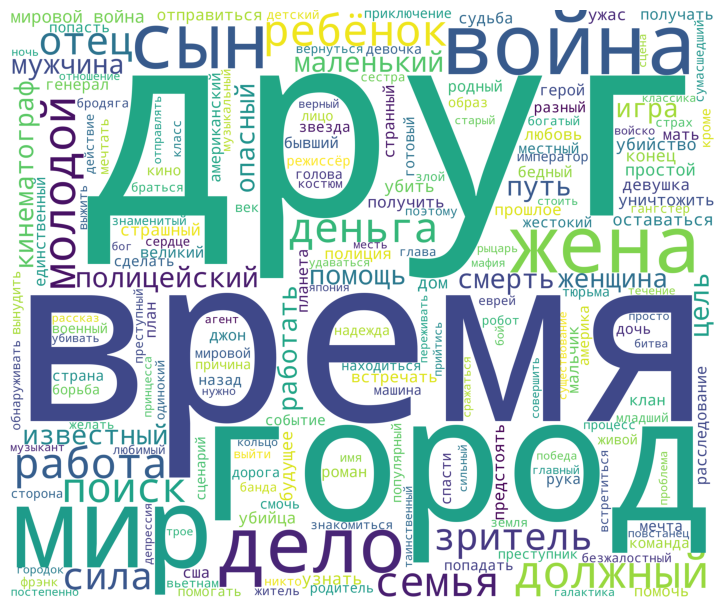

In [30]:
corpus = get_corpus(df['tokenize_text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

In [31]:
# Получение облака слов
def get_wordCloud2(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(corpus)
    return wordCloud

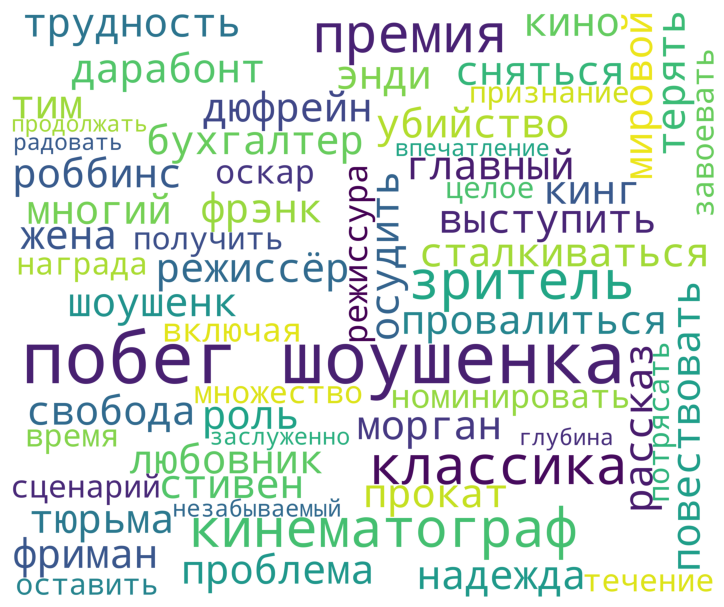

In [32]:
corpus = df['tokenize_text'][0]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

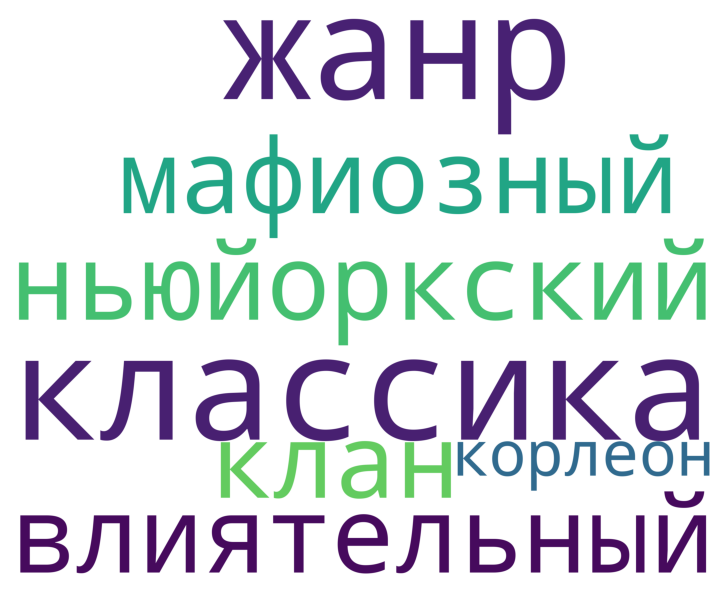

In [33]:
corpus = df['tokenize_text'][1]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

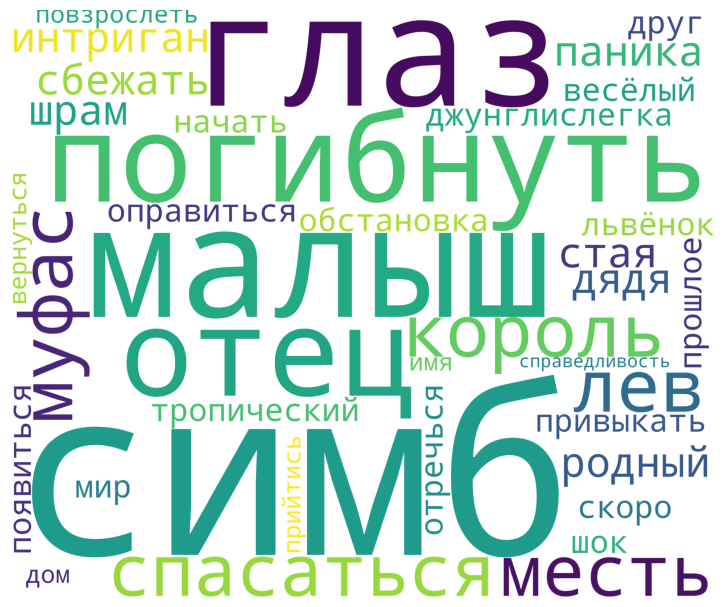

In [34]:
corpus = df['tokenize_text'][35]
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
plt.show()

# Векторизация текстовых данных

### TF-IDF

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [43]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tokenize_text'])

CPU times: total: 78.1 ms
Wall time: 74.3 ms


In [44]:
tfidf_matrix.shape

(249, 553)

- 249 — количество документов (текстов) в датасете.

- 553 — количество уникальных фичей (слов и N-грамм), оставшихся после фильтрации.

In [45]:
print(tfidf_matrix)

  (0, 79)	0.1537013361941686
  (0, 371)	0.1537013361941686
  (0, 152)	0.25805968287619724
  (0, 284)	0.1606836858212377
  (0, 338)	0.1606836858212377
  (0, 238)	0.1606836858212377
  (0, 231)	0.1537013361941686
  (0, 172)	0.2640243544474186
  (0, 176)	0.3074026723883372
  (0, 59)	0.09465333779774081
  (0, 485)	0.14799634115133914
  (0, 322)	0.12902984143809862
  (0, 473)	0.14317283657114754
  (0, 282)	0.1537013361941686
  (0, 353)	0.3213673716424754
  (0, 376)	0.1606836858212377
  (0, 227)	0.11192802862809051
  (0, 370)	0.1606836858212377
  (0, 418)	0.1537013361941686
  (0, 239)	0.14317283657114754
  (0, 484)	0.1537013361941686
  (0, 369)	0.14799634115133914
  (0, 451)	0.1606836858212377
  (0, 491)	0.13899452685077843
  (0, 128)	0.11192802862809051
  :	:
  (247, 363)	0.24633598718984168
  (247, 117)	0.17887974315875374
  (247, 226)	0.18314768357906758
  (247, 83)	0.37082300446342203
  (248, 542)	0.23477927818103705
  (248, 511)	0.23477927818103705
  (248, 326)	0.2245771783407666
  (248,

In [46]:
# Получение названий фичей по их индексам
tfidf_vectorizer.get_feature_names_out()[150:160]

array(['знать', 'золото', 'зритель', 'игра', 'играть', 'игрушка', 'идея',
       'известный', 'изз', 'изменить'], dtype=object)

# Тематическое моделирование

In [47]:
# библиотека для работы с векторными представлениями текстов
import gensim

In [48]:
def tokenize2(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens

In [49]:
df['tokenize_text2'] = [tokenize2(text) for text in df['tokenize_text']]

In [50]:
df.head()

,title,yearofrelease,description,rating,time,director,genre,prep_text,text_lemm,tokenize_text,tokenize_text2
0,Побег из Шоушенка,06.01.1995,"""Побег из Шоушенка"" - фильм, который считается...",9.44,142 мин.,Фрэнк Дарабонт,драма,побег из шоушенка фильм который считается одн...,побег из шоушенка фильм который считаться один...,побег шоушенка кино режиссёр выступить фрэнк д...,"[побег, шоушенка, кино, режиссёр, выступить, ф..."
1,Крестный отец,24.03.1972,"Фильм, ставший классикой своего жанра, рассказ...",9.11,175 мин.,Френсис Форд Коппола,драма,фильм ставший классикой своего жанра рассказыв...,фильм стать классика свой жанр рассказывать ис...,классика жанр влиятельный ньюйоркский мафиозны...,"[классика, жанр, влиятельный, ньюйоркский, маф..."
2,Темный рыцарь,24.03.1972,Бэтман вершит правосудие в Готэме. Его партнер...,9.12,152 мин.,Кристофер Нолан,боевик,бэтман вершит правосудие в готэме его партнера...,бэтман вершить правосудие в готэма он партнёр ...,бэтман вершить правосудие партнёр инспектор по...,"[бэтман, вершить, правосудие, партнёр, инспект..."
3,Крестный отец 2,12.12.1974,Продолжение эпохальной саги режиссера Френсиса...,8.88,202 мин.,Френсис Форд Коппола,драма,продолжение эпохальной саги режиссера френсиса...,продолжение эпохальный сага режиссёр френсиса ...,продолжение эпохальный сага режиссёр френсиса ...,"[продолжение, эпохальный, сага, режиссёр, френ..."
4,12 разгневанных мужчин,29.07.1957,Один из 12 присяжных в деле об убийстве пытае...,9.15,96 мин.,Сидни Люмет,детектив,один из 12 присяжных в деле об убийстве пытае...,один из 12 присяжный в дело о убийство пытатьс...,12 присяжный дело убийство убедить остальной п...,"[12, присяжный, дело, убийство, убедить, остал..."


В столбце tokenize_text2 теперь хранятся списки токенов (слов) после обработки.

In [51]:
# Создание словаря (Dictionary) из токенизированных текстов
gensim_dictionary = gensim.corpora.Dictionary(df['tokenize_text2'])
gensim_dictionary.filter_extremes(no_above=0.1, no_below=5) # фильтрация словаря
gensim_dictionary.compactify() # удаление "пропусков" после фильтрации

In [52]:
# doc2bow - преобразует в числовой формат
corpus = [gensim_dictionary.doc2bow(text) 
          for text in df['tokenize_text2']]

In [53]:
corpus

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1)],
 [],
 [(17, 1), (18, 1), (19, 1), (20, 1), (21, 1)],
 [(10, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(15, 1), (28, 2), (29, 1), (30, 1)],
 [(5, 1), (31, 2), (32, 1), (33, 1)],
 [(34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(41, 1), (42, 1)],
 [(43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)],
 [(22, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)],
 [(34, 1), (38, 1), (45, 1), (49, 1), (67, 1)],
 [(68, 1), (69, 2), (70, 1)],
 [(28, 1), (37, 1), (71, 1), (72, 1), (73, 1)],
 [(18, 1),
  (35, 1),
  (39, 1),
  (47, 1),
  (50, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1)],
 [(37, 1), (39, 2), (80, 1), (81, 1)]

# LDA

In [54]:
lda_10 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=10, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

In [55]:
lda_10.print_topics()

[(0,
  '0.032*"город" + 0.027*"мировой" + 0.026*"семья" + 0.025*"америка" + 0.024*"работа" + 0.022*"дом" + 0.020*"родный" + 0.020*"век" + 0.019*"миллион" + 0.018*"встречать"'),
 (1,
  '0.065*"жена" + 0.031*"бывший" + 0.025*"ребёнок" + 0.023*"голова" + 0.022*"отец" + 0.019*"маленький" + 0.016*"преступник" + 0.016*"гибель" + 0.015*"еврей" + 0.015*"борьба"'),
 (2,
  '0.046*"лицо" + 0.041*"мир" + 0.035*"поиск" + 0.026*"узнать" + 0.020*"уничтожить" + 0.020*"должный" + 0.020*"сила" + 0.020*"мальчик" + 0.020*"машина" + 0.020*"родитель"'),
 (3,
  '0.057*"работать" + 0.045*"полицейский" + 0.031*"команда" + 0.030*"молодой" + 0.028*"семья" + 0.025*"мир" + 0.023*"любовь" + 0.023*"ужас" + 0.023*"убить" + 0.023*"никто"'),
 (4,
  '0.045*"планета" + 0.034*"земля" + 0.029*"путь" + 0.026*"попадать" + 0.023*"должный" + 0.023*"девочка" + 0.023*"звезда" + 0.023*"обнаруживать" + 0.023*"принцесса" + 0.023*"император"'),
 (5,
  '0.049*"дело" + 0.037*"женщина" + 0.032*"цель" + 0.032*"судьба" + 0.029*"убийство"

In [56]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_10,
                                     texts=df["tokenize_text2"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()

print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.42447875815515956


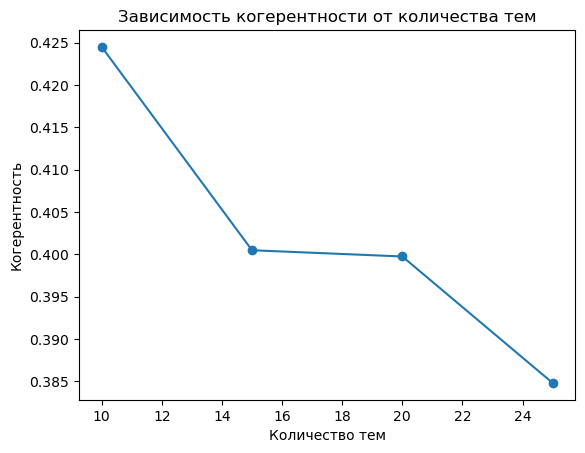

In [57]:
# Подбор оптимального количества тем
coherence_values = []
for num_topics in range(10, 30, 5):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                             num_topics=num_topics,
                             id2word=gensim_dictionary,
                             passes=10,
                             random_state=6457)
    
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=df["tokenize_text2"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
    
    coherence_values.append(coherence_model.get_coherence())

# Построение графика
import matplotlib.pyplot as plt

plt.plot(range(10, 30, 5), coherence_values, marker='o')
plt.xlabel("Количество тем")
plt.ylabel("Когерентность")
plt.title("Зависимость когерентности от количества тем")
plt.show()

График показывает, что когерентность максимальна при 10 темах (~0.425) и снижается при увеличении их числа. Оптимальное количество тем до 10, так как дальнейшее увеличение не улучшает качество.



In [58]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [59]:
vis_20 = gensimvis.prepare(lda_10, corpus, gensim_dictionary)

In [60]:
pyLDAvis.enable_notebook()

In [61]:
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.094109 -0.087154       1        1  13.557841
1      0.013780  0.030026       2        1  13.197200
7     -0.062564  0.104015       3        1  11.360662
5      0.008863 -0.019847       4        1  11.333553
0      0.086286  0.065747       5        1  10.347718
9      0.144923 -0.060694       6        1  10.047336
4     -0.211398 -0.074112       7        1   9.246817
2     -0.005540  0.118719       8        1   7.795804
3     -0.034056 -0.153755       9        1   6.771917
6     -0.034404  0.077055      10        1   6.341152, topic_info=            Term       Freq      Total Category  logprob  loglift
1           жена  19.000000  19.000000  Default  30.0000  30.0000
18         город  24.000000  24.000000  Default  29.0000  29.0000
91   полицейский  13.000000  13.000000  Default  28.0000  28.0000
42      работать  11.000000  11.000000  Default  27.0000  27.0000
28          дело  18.000000  18.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
1           жена   1.149031  19.497906  Topic10  -4.5640  -0.0733
183      процесс   0.975913   6.225469  Topic10  -4.7273   0.9051
70       мужчина   0.975898  12.454034  Topic10  -4.7274   0.2117
152        образ   0.975893   7.152927  Topic10  -4.7274   0.7662
52      действие   0.975891   6.209450  Topic10  -4.7274   0.9076

[413 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
190       3  0.416949       «
190       7  0.416949       «
190      10  0.138983       «
191       3  0.317712       »
191       7  0.476568       »
...     ...       ...     ...
59        8  0.079798    цель
59       10  0.079798    цель
99        4  0.187865  япония
99        5  0.187865  япония
99       10  0.563596  япония

[840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 8, 6, 1, 10, 5, 3, 4, 7])

Визуализация подтверждает, что темы интерпретируемы и логично разделены

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

In [63]:
# создание модели LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=0)
lda_model.fit(count_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: жена, время, страдать, рабство, ребёнок, план, молодой, известный, бывший, получать
Topic 1: полицейский, город, друг, знаменитый, любовь, генерал, мир, лосанджелес, поезд, сцена
Topic 2: мировой, война, кинематограф, зритель, время, режиссёр, жена, мир, должный, роль
Topic 3: время, друг, война, местный, мировой, помочь, семья, роман, искать, помощь
Topic 4: время, ребёнок, маленький, зритель, девочка, дело, сумасшедший, путь, молодой, город
Topic 5: джонс, отец, индиана джонс, индиана, поиск, сын, помощь, агент, дело, домой
Topic 6: сын, полиция, будущее, деньга, встретиться, младший, отец, работать, миллион, убить
Topic 7: война, город, должный, друг, мир, отправиться, мечта, ребёнок, сердце, лицо
Topic 8: друг, сын, дом, война, еврей, мировой, девушка, клан, детский, спасти
Topic 9: конец, война, класс, должный, команда, дело, девочка, семья, получить, сила


In [64]:
lda_model = LatentDirichletAllocation(learning_method='online', random_state=5, n_jobs=-1, n_components=11)
lda_model.fit(count_matrix)

LatentDirichletAllocation(learning_method='online', n_components=11, n_jobs=-1,
                          random_state=5)

In [65]:
#датафрейм для ключевых слов каждой темы
topic_keywords = pd.DataFrame()
for i,topic in enumerate(lda_model.components_):
    topic_keywords[f'Topic {i + 1}'] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-50:]]
topic_keywords

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11
0,кинг,вейдёр,готовый,режиссёр,сделать,ошибка,остров,житель,учёный,красивый,самоубийство
1,корлеон,тяжёлый,гитлер,положение,подружиться,выжить,чёрный,гнев,коварный,недавно,страна
2,ночь,император,страна,мастер,уважение,способный,сша,полицейский,наследница,вена,уехать
3,мафия,дарт вейдёр,время,рядовой отказаться,популярный,цель,молодой,преступный,мужчина,фортуна,новость
4,сын,убивать,убийца,война,робот,люк,джек,сумасшедший,грабитель,пригласить,беженец
5,безжалостный,дарт,заключить,восстановить,страшный,сын,известный,немец,никто,написать,миллион
6,имя,сила,вопрос,ждать,роман,легендарный,индиана джонс,оставить,игрушка,погибнуть,пенсильвания
7,простой,страшный,наркотик,америка,выжить,помощь,индиана,присоединяться,популярный,предать друг,родитель
8,американский,женщина,бомба,преступный,семья,искать,еврей,будущее,расследование,писатель,семья
9,тысяча доллар,повстанец,казаться,молодой,режиссёр,стечение обстоятельство,мировой,улица,немой,журналист,мировой


# NMF

In [66]:
from sklearn.decomposition import NMF

In [67]:
# создание модели NMF
nmf_model = NMF(n_components=10, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: ребёнок, город, девочка, маленький, пара, родитель, маленький девочка, странный, мать, голова
Topic 1: война, мировой война, мировой, ужас, еврей, время мировой, время мировой война, вьетнам, нацист, главный
Topic 2: дело, убийство, полицейский, расследование, женщина, расследовать, расследование дело, конец, убийца, фрэнк
Topic 3: друг, отправиться, друг друг, приключение, поиск, молодой, игрушка, город, люк, встречать
Topic 4: зритель, кинематограф, кино, получить, роль, классика, сценарий, популярный, премия, режиссёр
Topic 5: мужчина, жена, лицо, американский, экранизация, влюбляться, правило, дочь, план, процесс
Topic 6: путь, мир, сила, кольцо, уничтожить, команда, мечта, знаменитый, битва, саурон
Topic 7: работа, работать, век, 19го, 19го век, агент, должный, страна, деньга, предложение
Topic 8: время, америка, депрессия, великий, время великий, чернокожий, место, помогать, отношение, простой
Topic 9: семья, сын, младший, отец, брат, сестра, бедный, желать, младший брат

In [68]:
# создание модели NMF
nmf_model = NMF(n_components=5, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: ребёнок, город, работа, сын, маленький, отец, должный, мир, работать, девочка
Topic 1: война, мировой война, мировой, ужас, еврей, время мировой война, время мировой, американский, вьетнам, нацист
Topic 2: дело, убийство, полицейский, расследование, женщина, расследование дело, расследовать, убийца, конец, фрэнк
Topic 3: друг, отправиться, поиск, друг друг, люк, приключение, город, молодой, игрушка, планета
Topic 4: зритель, время, кинематограф, кино, получить, америка, классика, сценарий, роль, режиссёр


## Кластеризация

In [69]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for k in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    km = KMeans(n_clusters=k, n_init=10, random_state=111)
    labels = km.fit_predict(tfidf_matrix)
    print(f"k={k}: {silhouette_score(tfidf_matrix, labels):.3f}")

k=6: 0.006
k=7: 0.004
k=8: 0.006
k=9: 0.007
k=10: 0.006
k=11: 0.007
k=12: 0.009
k=13: 0.008
k=14: 0.008
k=15: 0.009


In [70]:
num_clusters = 9

# Метод к-средних - KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters)

In [71]:
%%time
km.fit(tfidf_matrix)

C:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 5.12 s
Wall time: 971 ms


KMeans(n_clusters=9)

In [72]:
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [73]:
len(km.labels_)

249

In [74]:
clusters[:10]

[6, 6, 7, 6, 7, 5, 5, 7, 2, 4]

In [75]:
clusterkm = km.labels_.tolist()
df['cluster']= clusterkm

In [76]:
df['cluster'].value_counts()

cluster
7    56
4    38
6    28
5    28
2    27
8    24
3    23
1    15
0    10
Name: count, dtype: int64

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_top_words(cluster_texts, n=10):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(cluster_texts)
    # Суммируем TF-IDF по всем документам кластера
    tfidf_sums = X.sum(axis=0).A1
    # Сортируем слова по убыванию важности
    top_indices = tfidf_sums.argsort()[-n:][::-1]
    return [vectorizer.get_feature_names_out()[i] for i in top_indices]

# Пример
for cluster_num in df['cluster'].unique():
    cluster_texts = df[df['cluster'] == cluster_num]['tokenize_text']
    top_words = get_tfidf_top_words(cluster_texts)
    print(f"\nКластер {cluster_num}: {', '.join(top_words)}")


Кластер 6: зритель, америка, получить, кино, приключение, кинематограф, классика, роман, костюм, американский

Кластер 7: дело, убийство, дочь, мужчина, работать, женщина, полиция, век, расследование, война

Кластер 5: война, время, мировой, ужас, маленький, мальчик, место, вьетнам, выжить, американский

Кластер 2: семья, сестра, младший, брат, сын, бедный, желать, тюрьма, суд, отец

Кластер 4: друг, город, встречать, девушка, отправиться, деньга, игрушка, молодой, приключение, поиск

Кластер 3: ребёнок, лицо, город, мир, родитель, мальчик, жена, единственный, чужой, коварный

Кластер 8: убить, будущее, джон, полицейский, класс, привести, мир, машина, акула, должный

Кластер 0: помогать, отношение, депрессия, время, великий, странный, бросить, угроза, бродяга, брать

Кластер 1: мошенник, фрэнк, агент, клиент, шаг, судьба, жена, сделать, искусный, работа


- Кластер 0: Психологические драмы и моральные дилеммы
- Кластер 1: Авантюры и героические квесты
- Кластер 2: Семейные драмы и социальные конфликты
- Кластер 3: Героические саги и личностные трансформации
- Кластер 4: Экстремальные путешествия и выживание
- Кластер 5: Военные драмы и исторические хроники
- Кластер 6: Кинематографическая классика и поп-культура
- Кластер 7: Криминальные триллеры и детективы
- Кластер 8: Нуар и интеллектуальные триллеры

In [78]:
for cluster_num in df['cluster'].unique():
    random_movies = df[df['cluster'] == cluster_num]['title'].sample(3, random_state=42)
    
    print(f"\nКластер {cluster_num}:")
    for i, title in enumerate(random_movies, 1):
        print(f"{i}. {title}")


Кластер 6:
1. Храброе сердце
2. Телесеть
3. Человек-паук: Через вселенные

Кластер 7:
1. Темный рыцарь
2. Молчание ягнят
3. Пленницы

Кластер 5:
1. Новые времена
2. Взвод
3. Касабланка

Кластер 2:
1. Охота
2. Нюрнбергский процесс
3. Пожары

Кластер 4:
1. Отель "Руанда"
2. В диких условиях
3. Назад в будущее

Кластер 3:
1. Человек-Паук 3: Нет пути домой
2. Индиана Джонс и последний крестовый поход
3. Бойцовский клуб

Кластер 8:
1. Однажды в Америке
2. В случае убийства набирайте "М"
3. Начало

Кластер 0:
1. Рататуй
2. Амадей
3. Убить пересмешника

Кластер 1:
1. Мистер Смит едет в Вашингтон
2. Волшебник страны Оз
3. Индиана Джонс: В поисках утраченного ковчега


### Классификация

In [79]:
# Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['tokenize_text'], df['cluster'], 
                                                      test_size=0.3, 
                                                      random_state=0)

In [80]:
len(X_train)

174

In [81]:
len(X_test)

75

In [82]:
# Импорт метрик и моделей машинного обучения
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [83]:
# Создание TF-IDF векторизатора для преобразования текстов в числовые признаки
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3), stop_words=russian_stopwords)
# Преобразование обучающих данных
X_train_tfidf = vectorizer.fit_transform(X_train)
# Преобразование тестовых данных
X_test_tfidf = vectorizer.transform(X_test)

## LogisticRegression

In [84]:
model_lr = LogisticRegression()
model_lr.fit(X_train_tfidf, y_train)

LogisticRegression()

In [85]:
y_pred = model_lr.predict(X_test_tfidf)

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         7
           4       1.00      0.27      0.43        11
           5       1.00      0.22      0.36         9
           6       0.00      0.00      0.00         9
           7       0.23      1.00      0.37        16
           8       0.00      0.00      0.00         9

    accuracy                           0.28        75
   macro avg       0.25      0.17      0.13        75
weighted avg       0.32      0.28      0.19        75



C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
X_test_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [88]:
y_pred

array([7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       4, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64)

## RandomForestClassifier

In [89]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [90]:
y_pred = model_rf.predict(X_test_tfidf)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         7
           3       1.00      0.29      0.44         7
           4       0.75      0.27      0.40        11
           5       0.67      0.44      0.53         9
           6       0.00      0.00      0.00         9
           7       0.25      1.00      0.41        16
           8       0.00      0.00      0.00         9

    accuracy                           0.33        75
   macro avg       0.30      0.22      0.20        75
weighted avg       0.34      0.33      0.25        75



C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNeighborsClassifier

In [92]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [93]:
y_pred = model_knn.predict(X_test_tfidf)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.33      0.50      0.40         4
           2       0.50      0.43      0.46         7
           3       0.36      0.57      0.44         7
           4       0.67      0.73      0.70        11
           5       0.45      0.56      0.50         9
           6       0.40      0.44      0.42         9
           7       0.64      0.44      0.52        16
           8       0.67      0.22      0.33         9

    accuracy                           0.51        75
   macro avg       0.51      0.54      0.50        75
weighted avg       0.54      0.51      0.50        75



### Рейтинг моделей по эффективности

Сравнение моделей по accuracy:

- LogisticRegression: 0.28
- Random Forest: 0.33
- ✅ KNN: 0.51

__Выбор__: KNeighborsClassifier, так как она демонстрирует:

- Наивысшую точность (accuracy = 0.51).
- Более сбалансированные показатели precision(точность) и recall(полнота) для большинства классов.
- Лучший macro avg и weighted avg по f1-score.

## Сохранение моделей

In [95]:
import pickle

with open('model_knn1.pkl', 'wb') as f:
    pickle.dump(model_knn, f)

In [96]:
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [97]:
df.to_csv('data_movies.csv')